In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from astropy.io import fits
from glob import glob
from astropy.table import Table

import sys
sys.path.insert(0, '../../aesop/')
sys.path.insert(0, '../')

In [2]:
from aesop import EchelleSpectrum

# Spectroscopic standard: 
from astropy.utils.data import download_file
spectroscopic_standard_url = 'http://staff.washington.edu/bmmorris/docs/BD28_4211.0034.wfrmcpc.fits'
standard_path = download_file(spectroscopic_standard_url, cache=True) 
standard_spectrum = EchelleSpectrum.from_fits(standard_path)

In [3]:
stacked_spectra_paths = glob('../data/wavelength_calibrated/*wfrmcpc.fits')

all_spectra = []

for path in stacked_spectra_paths:
    spectrum = EchelleSpectrum.from_fits(path)
    spectrum.continuum_normalize_from_standard(standard_spectrum,
                                               polynomial_order=8)
    spectrum.continuum_normalize_lstsq(polynomial_order=2)

#     for i in np.arange(len(spectrum)):
#         wl_correction = spectrum.rv_wavelength_shift(i, T_eff=4600)
#         spectrum[i].wavelength += wl_correction 

    wavelength_offsets = spectrum.rv_wavelength_shift_ransac()
    spectrum.offset_wavelength_solution(wavelength_offsets)

    spec1d = spectrum.to_Spectrum1D()
    
    all_spectra.append(spec1d)
    #spec_output = np.vstack([spec1d.wavelength, spec1d.flux]).T
    #table = Table(spec_output, names=['wavelength', 'flux'])
    
    #out_path = os.path.basename(path).split('.')[0] + '.csv'
    #table.write(os.path.join('tables', out_path), format='ascii.fast_csv')

<IPython.core.display.Javascript object>


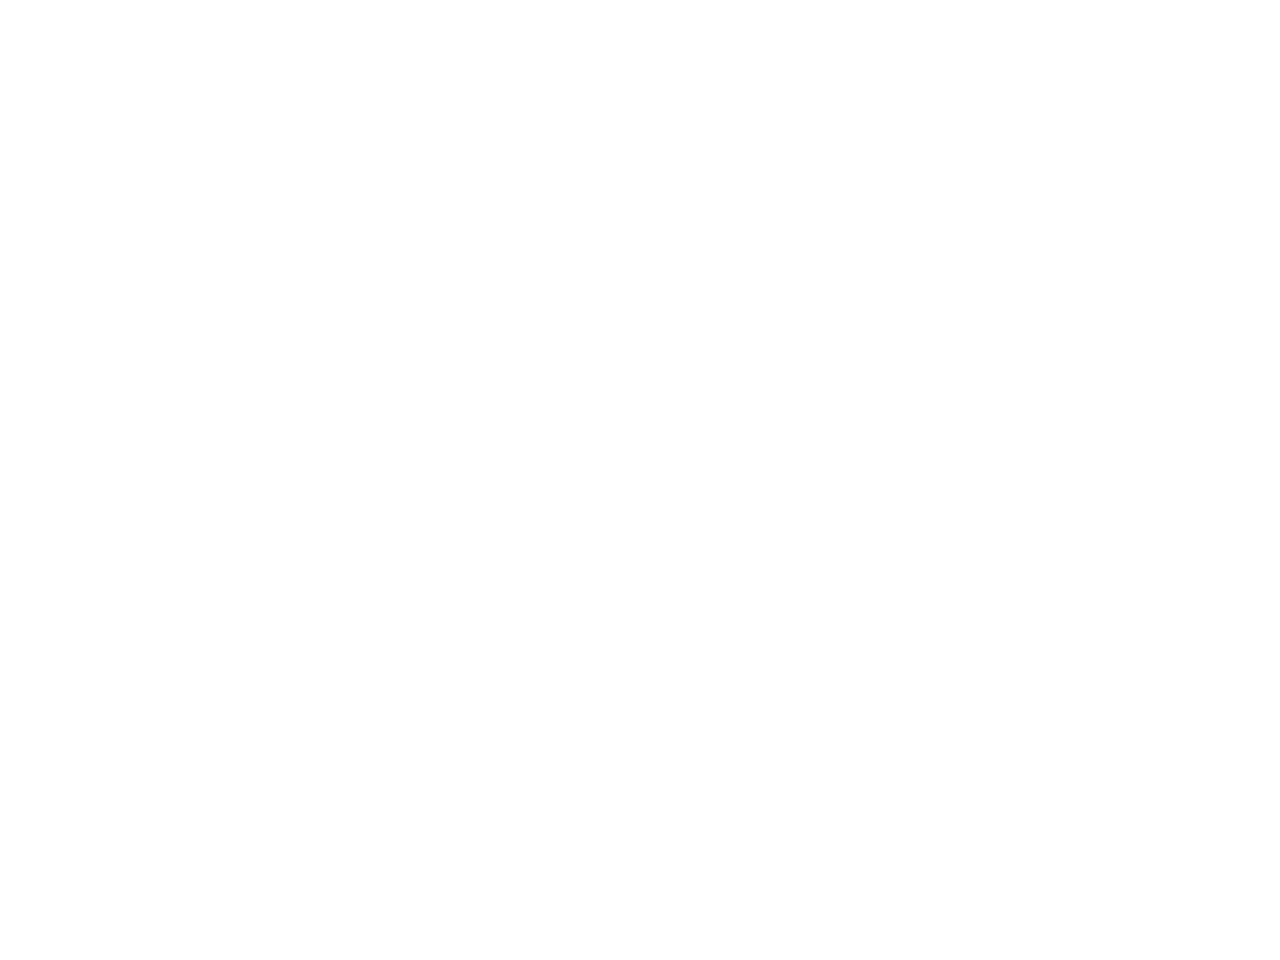

In [4]:
%matplotlib notebook
plt.figure()

for spec in all_spectra:
    spec.plot()

plt.ylim([0, 5])
plt.show()

In [22]:
total_exp_time = 0

dates = []

for spec in all_spectra:
    date = spec.meta['header']['DATE-OBS']
    print(spec.meta['header']['OBJNAME'], date)
    total_exp_time += spec.meta['header']['EXPTIME']
    dates.append(date)
    
from astropy.time import TimeDelta
times = Time(dates, format='isot', scale='tai')

days_elapsed = TimeDelta(times.jd.max() - times.jd.min(), format='jd').jd
days_elapsed

EPIC 211928486 2017-11-28T11:15:27.046
EPIC 211928486 2017-12-04T08:44:20.267
EPIC 211928486 2017-12-08T10:03:20.777
EPIC 211928486 2017-12-11T10:18:21.533
EPIC 211928486 2017-12-14T09:18:29.306
EPIC 211966629 2017-12-04T08:06:42.238
EPIC 211966629 2017-12-08T10:37:14.690
EPIC 211966629 2017-12-11T09:34:32.240
EPIC 211966629 2017-12-14T10:33:37.405


15.970953229349107

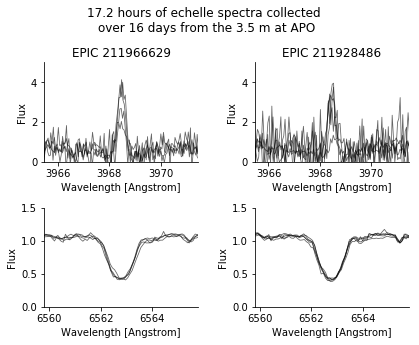

In [35]:
%matplotlib inline

cah = 3968.468
ha = 6562.8

lines = [cah, ha]

alpha = 0.6
fig, ax = plt.subplots(len(lines), 2, figsize=(6, 5))
for spec in all_spectra:
    target_name = spec.meta['header']['OBJNAME']

    for row in range(len(lines)):
        if '211966629' in target_name: 
            spec.plot(ax=ax[row, 0], color='k', alpha=alpha, lw=0.8)
        else: 
            spec.plot(ax=ax[row, 1], color='k', alpha=alpha, lw=0.8)
            
ax[0, 0].set_title('EPIC 211966629')
ax[0, 1].set_title('EPIC 211928486')

for row in [ax[:, 0], ax[:, 1]]:
    for i, axis in enumerate(row): 
        axis.set_xlim([lines[i] - 3, lines[i] + 3])
        
        if i == 0:
            axis.set_ylim([0, 5])
        elif i == 1:
            axis.set_ylim([0, 1.5])
            
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.suptitle("{0:.1f} hours of echelle spectra collected \nover {1:.0f}"
             " days from the 3.5 m at APO"
             .format(total_exp_time/60/60, days_elapsed))
fig.savefig('quicklook.pdf', bbox_inches='tight')